In [1]:
import signVerify
import hashlib
import DataBaseConection
from CertificateFunctions import cert_gen, check_associate_cert_with_private_key, VerificarVigencia, Hash_document, VerificarPassword

In [2]:
database = DataBaseConection.DataBase(user = "root", password = "", db = "teleton")

Conexión exitosa


# Ejemplo de uso del sistema

## Creando usuarios

### Creando certificados

In [3]:
nombre_1 = "Jairo Enrique R"
password_1 = "prueba"
nomina_1 = "A01750442"
email_1 = "A01750442@tec.mx"

nombre_2 = "Ramirez Sanchez R"
nomina_2 = "A01752067"
password_2 = "prueba2"
email_2 = "A01752067@tec.mx"


cert_gen(emailAddress=email_1,
    commonName="tec.mx",
    countryName="MX",
    localityName="Monterrey",
    stateOrProvinceName="Nuevo León",
    organizationName="Tecnológico de Monterrey",
    organizationUnitName="organizationUnitName",
    serialNumber=0,
    validityStartInSeconds = 0,
    validityEndInSeconds = 1*365*24*60*60, #UN AÑO
    KEY_FILE = "Ejemplo/private"+nomina_1.replace(" ","_")+".key",
    CERT_FILE="Ejemplo/Certificado"+nomina_1.replace(" ","_")+".crt")

cert_gen(emailAddress=email_2,
    commonName="tec.mx",
    countryName="MX",
    localityName="Monterrey",
    stateOrProvinceName="Nuevo León",
    organizationName="Tecnológico de Monterrey",
    organizationUnitName="organizationUnitName",
    serialNumber=0,
    validityStartInSeconds = 0,
    validityEndInSeconds = 1*365*24*60*60, #UN AÑO
    KEY_FILE = "Ejemplo/private"+nomina_2.replace(" ","_")+".key",
    CERT_FILE="Ejemplo/Certificado"+nomina_2.replace(" ","_")+".crt")

print("Firmas generadas")
print("Guarde su llave privada en un lugar aparte")
print("-------------------\n")
print("Subiendo certificado a la base de datos")

database.insert_users(nomina = nomina_1,
                password=hashlib.sha256(bytes(password_1, encoding="utf-8")).hexdigest(),
                nombre = nombre_1,
                puesto = "Estudiante",
                tags = "IDM",
                certificado = f"Ejemplo/Certificado{nomina_1}.crt",
                estatus = "Activo")

database.insert_users(nomina = nomina_2,
                password = hashlib.sha256(bytes(password_2, encoding="utf-8")).hexdigest(),
                nombre = nombre_2,
                puesto = "Estudiante",
                tags = "IDM",
                certificado = f"Ejemplo/Certificado{nomina_2}.crt",
                estatus = "Activo")

Firmas generadas
Guarde su llave privada en un lugar aparte
-------------------

Subiendo certificado a la base de datos
Jairo Enrique R ha sido añadido a la base de datos.
Ramirez Sanchez R ha sido añadido a la base de datos.


## Solicitar firma

In [4]:
#Primero se sube el documento que se quiere firmar con todos los datos de indentificación
file_1 = "Ejemplo/Doc_1.pdf"

database.insert_documentos(Hash = Hash_document(file_1).hexdigest(), 
                           Tipo = "Libro", 
                           Nombre = "Doc_1.pdf", 
                           Descripcion = "Justine o los infortunios de la virtud",
                           Tags = "Marqués de Sade",
                           Estatus = "Activo")

file_2 = "Ejemplo/Doc_2.pdf"

database.insert_documentos(Hash = Hash_document(file_2).hexdigest(), 
                           Tipo = "Libro", 
                           Nombre = "Doc_2.pdf", 
                           Descripcion = "Suenio de una noche de verano",
                           Tags = "Shakespeare",
                           Estatus = "Activo")

Doc_1.pdf ha sido añadido a la base de datos.
Doc_2.pdf ha sido añadido a la base de datos.


In [5]:
# Se solicitan las firmas de los empleados. 
# Se carga a la base de datos el hash del documento y la nómina de quien lo firmará, se deja vacío por default 
# espacio para el archivo de firma.
database.insert_firma(Hash = Hash_document(file_1).hexdigest(),
                Nomina = nomina_1)

database.insert_firma(Hash = Hash_document(file_1).hexdigest(),
                Nomina = nomina_2)

database.insert_firma(Hash = Hash_document(file_2).hexdigest(),
                Nomina = nomina_1)

50df68716b0074ebd4e5f2ccb5b378d89a8a174128394a57654d4410d4a268e5 ha sido añadido a la base de datos.
50df68716b0074ebd4e5f2ccb5b378d89a8a174128394a57654d4410d4a268e5 ha sido añadido a la base de datos.
529408553f25564439f509c3554f3ad705848bff071f5342825f20a051c29264 ha sido añadido a la base de datos.


## Generar el archivo firmado

In [6]:
# Obtiene el certificado de la base de datos del usuario tomando su nómina
file_1 = "Ejemplo/Doc_1.pdf"
Certificado_1 = database.select(tabla = "users", 
                what = "Certificado", 
                where = "Nomina", 
                value = nomina_1)[0][0]

# Se carga la llave privada del usuario

private_key_1 = "Ejemplo/privateA01750442.key"

#Se verifica la vigencia para saber si es posible firmar el documento

VerificarVigencia(Certificado_1)

#Se valida si la llave privada coincide con el certificado almacenado, es decir, que quien quiera firmar sea quien dice ser.

Match = check_associate_cert_with_private_key(Certificado_1, private_key_1)
print()

if Match:
    # se generar el archivo de firma digital
    file_name = signVerify.gen_signature(private_key_1, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), file_1, nomina_1)
    print(f"Archivo firmado en {file_name}")

    print("\n Cargando la firma a la base de datos")
    database.cargar_firma(Doc_signed = file_name,
                     Hash = Hash_document(file_1).hexdigest(),
                     Nomina = nomina_1)
else:
    print("La llave privada no coincide con el certificado.\nNo puede firmar este documento.")

print("\n-------------------------------\n")

Certificado_2 = database.select(tabla = "users", 
                what = "Certificado", 
                where = "Nomina", 
                value = nomina_2)[0][0]

private_key_2 = "Ejemplo/privateA01752067.key"

VerificarVigencia(Certificado_2)

Match = check_associate_cert_with_private_key(Certificado_2, private_key_2)

if Match:

    file_name = signVerify.gen_signature(private_key_2, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), file_1, nomina_2)
    print(f"Archivo firmado en {file_name}")

    print("\n Cargando la firma a la base de datos")
    database.cargar_firma(Doc_signed = file_name,
                     Hash = Hash_document(file_1).hexdigest(),
                     Nomina = nomina_2)
else:
    print("La llave privada no coincide con el certificado.\nNo puede firmar este documento.")

Certificado vigente

Archivo firmado en Ejemplo/Doc_1.pdf_A01750442_20220421_105711.sign

 Cargando la firma a la base de datos

-------------------------------

Certificado vigente
Archivo firmado en Ejemplo/Doc_1.pdf_A01752067_20220421_105711.sign

 Cargando la firma a la base de datos


## Verificar firma

In [7]:
# Es cargado el documento a verificar
file_1 = "Ejemplo/Doc_1.pdf"
file_2 = "Ejemplo/Doc_2.pdf"

#Se emula que se suben los certificados

#Se cargan los certificados de las personas que se quieren validar
Certificado_1 = "Ejemplo/CertificadoA01750442.crt"
nomina_1 = "A01750442"
Certificado_2 = "Ejemplo/CertificadoA01752067.crt"

# Se extraé de la base de datos el archivo firmado que coincida con el hash del documento y la nómina
f = database.select(tabla = "firmas", 
                what = "Doc_signed", 
                where = "Hash", 
                value = Hash_document(file_1).hexdigest(),
                where_2 = "Nomina",
                value_2 = nomina_1)[0][0]

if f != None:
    # Si el archvio existe, se valida la firma
    open("Ejemplo/temp.sign", "wb").write(f)

    result = signVerify.verify(Certificado_1, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), "Ejemplo/temp.sign", load = True)
    if result:
        print(f"Verificación exitosa. \nEl archivo fue firmado correctamente por {nomina_1}")
    else:
        print(f"Verificación fallida. \nEl archivo no firmado por {nomina_1}")

else:
    # Si el archivo aún no existe, tiene pendiente la firma
    print(f"El archivo aún no cuenta con la firma de {nomina_1}")


Verificación exitosa. 
El archivo fue firmado correctamente por A01750442


In [7]:
VerificarPassword("A01750442", "prueba", database)

True

In [8]:
import matplotlib.pyplot as plt

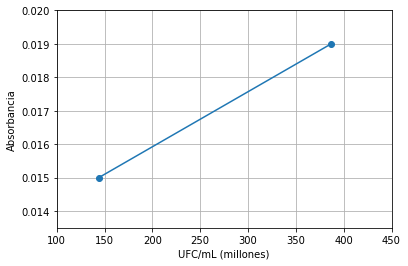

In [31]:
plt.plot([144, 387], [0.015, 0.019], marker="o")
plt.grid()
plt.xlabel(r"UFC/mL (millones)")
plt.ylabel("Absorbancia")
plt.title("")
plt.xlim([100, 450])
plt.ylim([0.0135, 0.02])
plt.show()
